# Classifier architecture design
Have a couple of ideas to play with here. Let's give the following a college try:

- **Tiling**: Break the data into overlapping chunks by fragment length. Then train a classifier on each chunk. A given fragment will then fall in the length range of n classifiers. Combine the outputs somehow in a clever way, could even train a second tier of classifiers that take the output from the first stages to make the final prediction.
- **Clustering**: Can we somehow cluster text by similarity and then train a classifier for each cluster?
- **Bagging**: Train n classifiers on n random subsets of the data. Then a 'master' classifier to combine the outputs.

Note about the classifier: will be using XGBoost - it's the fastest of the bunch from the preliminary classifier selection results and, after optimization has the best balance of false positive and false negative rates. I also can be used via the scikit-learn API, so any other classifier from scikit is a drop in replacement. This can obviously be re-evaluated later, but for now, it's a good starting point.

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate

import configuration as config
import functions.notebook_helper as helper_funcs
import functions.notebook_plotting as plot_funcs

/mnt/arkk/llm_detector/classifier


## 1. Load and prepare data
Let's take a look:

In [2]:
# The dataset - omit the file extension, it will be
# added appropriately for the input and output files
dataset_name = 'falcon-7b_scores_v2_10-300_words'

# Input file path
working_hdf5_file = f'{config.DATA_PATH}/{dataset_name}_stage_I.h5'

# Open a connection to the hdf5 dataset via PyTables with Pandas so we can
# load the data from each bin as a dataframe
data_lake = pd.HDFStore(working_hdf5_file)

# Load bin data
data_df = data_lake[f'master']

# Take small sample for rapid development and testing
data_df = data_df.sample(n = 5000)

# Close hdf5 connection
data_lake.close()

data_df.info()
data_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 45545 to 28616
Data columns (total 22 columns):
 #   Column                                                                  Non-Null Count  Dtype  
---  ------                                                                  --------------  -----  
 0   Fragment ID                                                             5000 non-null   int64  
 1   Source record num                                                       5000 non-null   int64  
 2   Fragment length (words)                                                 5000 non-null   int64  
 3   Fragment length (tokens)                                                5000 non-null   int64  
 4   Dataset                                                                 5000 non-null   object 
 5   Source                                                                  5000 non-null   object 
 6   Generator                                                               5000 non

,Fragment ID,Source record num,Fragment length (words),Fragment length (tokens),Dataset,Source,Generator,String,Perplexity,Cross-perplexity,...,Writer time (seconds),Reader peak memory (GB),Writer peak memory (GB),Human TF-IDF,Synthetic TF-IDF,TF-IDF score,Synthetic-human TF-IDF exponential gaussian fit Kullback-Leibler score,Human-synthetic TF-IDF exponential gaussian fit Kullback-Leibler score,Synthetic-human TF-IDF kernel density estimate Kullback-Leibler score,Human-synthetic TF-IDF kernel density estimate Kullback-Leibler score
45545,42526,9337,242,323,pubmed,human,human,and vas back at 12 months showed no significan...,2.988,2.945312,...,5.039728,6.761486,6.719900,-3.327739,-3.284153,0.288188,0.060676,0.066595,0.060676,0.066595
13828,42222,9293,82,109,pubmed,human,human,six cases with php1b ( 3 males and 3 females )...,3.428,3.175781,...,2.160094,5.808176,5.765305,-3.231675,-3.308466,-0.502221,0.112577,0.033060,0.112577,0.033060
8026,34884,8187,31,43,cnn,human,human,and a private bathing beach. ‘I have the most ...,3.037,3.582031,...,1.145495,5.045394,5.025036,-3.285347,-3.298927,-0.089414,0.091305,0.044984,0.091305,0.044984
54077,39187,8838,237,307,cnn,synthetic,llama2-13b,"""The video is reprehensible and is in no way r...",2.375,2.703125,...,4.286929,7.734767,7.651464,-2.909281,-2.909604,-0.001876,0.084424,0.049358,0.084424,0.049358
10784,29266,7340,57,77,cnn,human,human,has kept the same silhouette of an apple since...,3.865,3.388672,...,2.102365,6.848012,6.754371,-3.375509,-3.315404,0.402155,0.052263,0.073626,0.052263,0.073626


OK, let's get the data into shape to train a classifier.

In [3]:
# Split the data into training and testing
training_data_df = data_df.sample(frac = 0.7, random_state = 42)
testing_data_df = data_df.drop(training_data_df.index)

# Set length threshold
training_data_df = training_data_df[training_data_df['Fragment length (words)'] > 50].copy()
testing_data_df = testing_data_df[testing_data_df['Fragment length (words)'] > 50].copy()

# Remove rows containing NAN
training_data_df.dropna(inplace = True)
testing_data_df.dropna(inplace = True)

# Drop un-trainable features
feature_drops = [
    'Fragment ID',
    'Source record num',
    'Dataset',
    'Generator',
    'String',
    'Reader time (seconds)',
    'Writer time (seconds)',
    'Reader peak memory (GB)',
    'Writer peak memory (GB)',
    'Fragment length (words)'
]

training_data_df.drop(feature_drops, axis = 1, inplace = True)
testing_data_df.drop(feature_drops, axis = 1, inplace = True)

# Split the data into features and labels
labels_train = training_data_df['Source']
features_train_df = training_data_df.drop('Source', axis = 1)

labels_test = testing_data_df['Source']
features_test_df = testing_data_df.drop('Source', axis = 1)

# Encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(labels_train)
labels_train = label_encoder.transform(labels_train)
labels_test = label_encoder.transform(labels_test)

print(f'Training data: {len(features_train_df)} examples')
print(f'Test data: {len(features_test_df)} examples')

Training data: 2804 examples
Test data: 1201 examples


Make a data structure to collect results for plotting as we go.

In [4]:
# Dictionary to hold testing/experimentation results
results = {
    'Fold': [],
    'Condition': [],
    'Fit time (sec.)': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

# Plots to draw
plots = ['Fit time (sec.)', 'Accuracy (%)', 'False positive rate', 'False negative rate', 'Binary cross-entropy']

# Make evaluation metrics scorers
scoring = {
    'binary_cross_entropy': make_scorer(helper_funcs.binary_cross_entropy), 
    'accuracy': make_scorer(helper_funcs.percent_accuracy),
    'false_positive_rate': make_scorer(helper_funcs.false_positive_rate),
    'false_negative_rate': make_scorer(helper_funcs.false_negative_rate)
}

# Set some parameters
cv_folds = 3
random_state = 23

## 2. Fragment length tiling

Plan here is to break the data into chunks based on fragment length and then train a classifier for each bin. Let's see if it works.

In [5]:
# Bin the data
bins = pd.cut(training_data_df.loc[:, 'Fragment length (tokens)'], 5)

training_data_df.loc[:, 'Length bin (tokens)'] = bins
training_data_df = training_data_df.astype({'Length bin (tokens)': str})

training_data_df.info()
training_data_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2804 entries, 13313 to 46793
Data columns (total 13 columns):
 #   Column                                                                  Non-Null Count  Dtype  
---  ------                                                                  --------------  -----  
 0   Fragment length (tokens)                                                2804 non-null   int64  
 1   Source                                                                  2804 non-null   object 
 2   Perplexity                                                              2804 non-null   float64
 3   Cross-perplexity                                                        2804 non-null   float64
 4   Perplexity ratio score                                                  2804 non-null   float64
 5   Human TF-IDF                                                            2804 non-null   float64
 6   Synthetic TF-IDF                                                        2804 non

,Fragment length (tokens),Source,Perplexity,Cross-perplexity,Perplexity ratio score,Human TF-IDF,Synthetic TF-IDF,TF-IDF score,Synthetic-human TF-IDF exponential gaussian fit Kullback-Leibler score,Human-synthetic TF-IDF exponential gaussian fit Kullback-Leibler score,Synthetic-human TF-IDF kernel density estimate Kullback-Leibler score,Human-synthetic TF-IDF kernel density estimate Kullback-Leibler score,Length bin (tokens)
13313,362,human,2.404,2.402344,1.000813,-2.942172,-2.854166,0.510110,0.045333,0.079882,0.045333,0.079882,"(348.4, 447.2]"
31121,66,synthetic,2.473,2.378906,1.039409,-2.939232,-2.992130,-0.313754,0.105776,0.036636,0.105776,0.036636,"(51.506, 150.8]"
54700,83,synthetic,2.824,3.166016,0.892042,-3.152652,-3.147846,0.030279,0.081801,0.051095,0.081801,0.051095,"(51.506, 150.8]"
45710,89,human,3.002,3.097656,0.969105,-3.041201,-3.055322,-0.086092,0.091053,0.045140,0.091053,0.045140,"(51.506, 150.8]"
38840,393,human,1.983,2.035156,0.974568,-3.240028,-3.174370,0.421157,0.050962,0.074765,0.050962,0.074765,"(348.4, 447.2]"


In [6]:
# Grab the bin strings
bin_strings = list(training_data_df['Length bin (tokens)'].unique())
bin_strings.sort()
print(bin_strings)

['(150.8, 249.6]', '(249.6, 348.4]', '(348.4, 447.2]', '(447.2, 546.0]', '(51.506, 150.8]']


Bin: (150.8, 249.6]
Training data: 832 examples
Bin: (249.6, 348.4]
Training data: 718 examples
Bin: (348.4, 447.2]
Training data: 357 examples
Bin: (447.2, 546.0]
Training data: 27 examples
Bin: (51.506, 150.8]
Training data: 870 examples


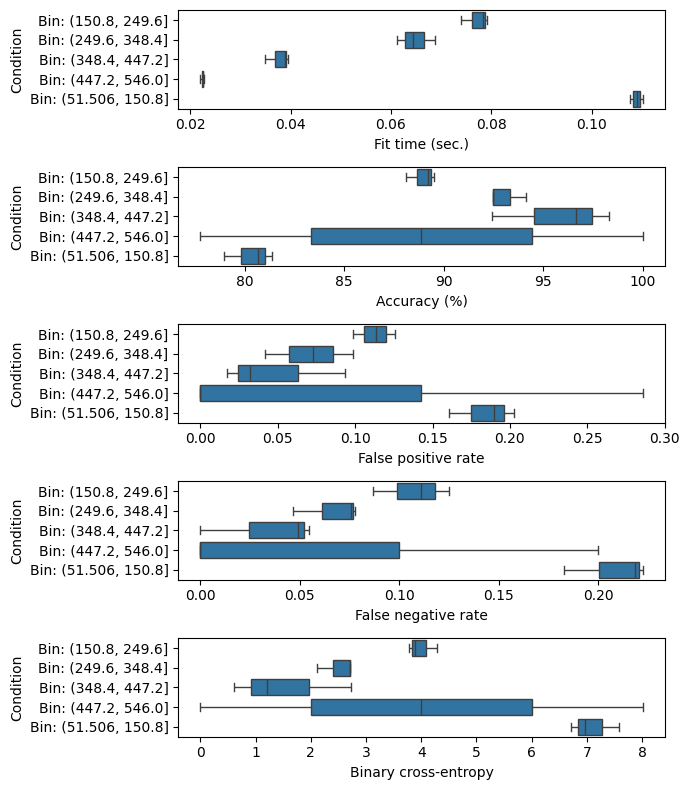

In [7]:
# Loop on the bins
for bin_string in bin_strings:
    print(f'Bin: {bin_string}')

    # Grab the data for this bin
    bin_training_data = training_data_df[training_data_df['Length bin (tokens)'] == bin_string]

    # Split the data into features and labels
    labels_train = bin_training_data['Source']
    features_train_df = bin_training_data.drop('Source', axis = 1)

    # Encode string class values as integers
    label_encoder = LabelEncoder()
    label_encoder = label_encoder.fit(labels_train)
    labels_train = label_encoder.transform(labels_train)

    # Drop the bin string and make a numpy copy
    features_train_df = features_train_df.drop('Length bin (tokens)', axis = 1)
    features_train = features_train_df.to_numpy()

    print(f'Training data: {len(labels_train)} examples')

    # Instantiate an XGBoost model
    model = XGBClassifier()

    # Run cross-validation
    scores = cross_validate(
        model,
        features_train,
        labels_train,
        cv = cv_folds,
        n_jobs = -1,
        scoring = scoring
    )

    # Collect and plot the results
    results = helper_funcs.add_cv_scores(results, scores, f'Bin: {bin_string}')

plot_funcs.plot_cross_validation(plots, results).show()

So, I think this might have potential - it's the short fragments that are killing our accuracy. What I don't know is if we were to build a compound classifier out of models trained on each bin, would it do any better overall than one classifier trained with length as a feature. Seems like it could - the short bin gives 88% accuracy, which is about what we get with a single classifier. The other long bins score in the mid/high 90s and contain more data together than the short bin.